In [ ]:
# Time Series Forecasting using Recurrent Neural Networks (RNNs)
# This is a univariant time series to predict forex prices

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
# Out dataset contains a number of features: Spot price, open price, high price, low price and change. This data was collected everyday from December 1st until now. 
# This dataset was collected by the uk.investing.com. This data shows how much the dollar was worth compare to the sterling.
# Downloading dataset and read into pandas dataframe
concrete_data= pd.read_csv('forex.csv')
# This allows us to see the dataset
concrete_data.head()
# As you can see one observation is given everyday.
# If you wanted to predict 3 day in the future. In order to make this prediction, you choose to use 2 days of observations.
# Thus you would create a window containing the last 2(2*1) observations to train the model. 



,Date,Price,Open,High,Low,Change %
0,"Jul 03, 2020",1.2482,1.2466,1.2493,1.2439,0.12%
1,"Jul 02, 2020",1.2467,1.2476,1.2531,1.2456,-0.05%
2,"Jul 01, 2020",1.2474,1.2401,1.2492,1.2358,0.59%
3,"Jun 30, 2020",1.2401,1.2298,1.2402,1.2257,0.83%
4,"Jun 29, 2020",1.2299,1.2340,1.2391,1.2251,-0.30%


In [ ]:
# The function below returns the above descriped windows of days for the model to train on.
# The parameter history_size is the size of the past window of information.
# The target_size is how far in the future does the model need to learn to predict.
# The target_size if the label that needs to be predicted.

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [ ]:
# The first 100 rows of the data will be the training dataset, and there remaining 34 will be the validation dataset
# Amounting to 100 days of training data.
TRAIN_SPLIT = 100 
# Setting seed to ensure reproducibility
tf.random.set_seed(13)

In [ ]:
# First, you will train a model using only a single feature (spot price), and use it 
# to make predictions for that value in the future.
# Let's first extract only the spot price from the dataset. 
uni_data = concrete_data['Price']
uni_data.index = concrete_data['Date']
uni_data.head()

Date
Jul 03, 2020    1.2482
Jul 02, 2020    1.2467
Jul 01, 2020    1.2474
Jun 30, 2020    1.2401
Jun 29, 2020    1.2299
Name: Price, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc2c06dc50>],
      dtype=object)

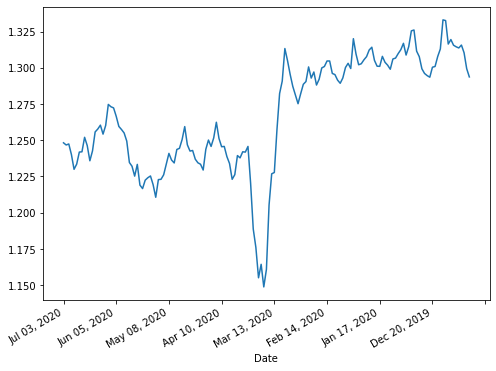

In [ ]:
# How data looks across time
uni_data.plot(subplots=True)

In [ ]:
uni_data = uni_data.values


In [ ]:
# It is important to scale features before training a neural network. 
# Standardization is a common way of doing this scaling by subtracting 
# the mean(average flux) and dividing by the standard deviation of each feature.You 
# could also use a tf.keras.utils.normalize method that rescales the 
# values into a range of [0,1].
# Standard Deviation tells you how spread out the data is.
# The mean and standard deviation should only be calculated using the training data
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [ ]:
# We then standardize the data
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [ ]:
# Let's now create the data for the univariate model. 
# For part 1, the model will be given the last 24 recorded 
# temperature observations, and needs to learn to predict 
# the spot price at the next day step.
univariate_past_history = 34
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target Forex Spot Price to predict')
print (y_train_uni[0])

Single window of past history
[[ 0.08169685]
 [ 0.03379017]
 [ 0.05614662]
 [-0.17699919]
 [-0.50276458]
 [-0.38778856]
 [-0.12270496]
 [-0.11631741]
 [ 0.20306042]
 [ 0.02101506]
 [-0.31433166]
 [-0.09715474]
 [ 0.32123022]
 [ 0.38510579]
 [ 0.4713378 ]
 [ 0.27332355]
 [ 0.46495024]
 [ 0.92804809]
 [ 0.87694764]
 [ 0.85139742]
 [ 0.66615828]
 [ 0.4425938 ]
 [ 0.37552445]
 [ 0.29887377]
 [ 0.12002219]
 [-0.352657  ]
 [-0.43569523]
 [-0.65287216]
 [-0.39417612]
 [-0.85088641]
 [-0.92753709]
 [-0.74229795]
 [-0.68800372]
 [-0.64967838]]

 Target Forex Spot Price to predict
-0.841305076348232


In [ ]:
# Now that the data has been created, let's take a look at a 
# single example. The information given to the network is given 
# in blue, and it must predict the value at the red cross.
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

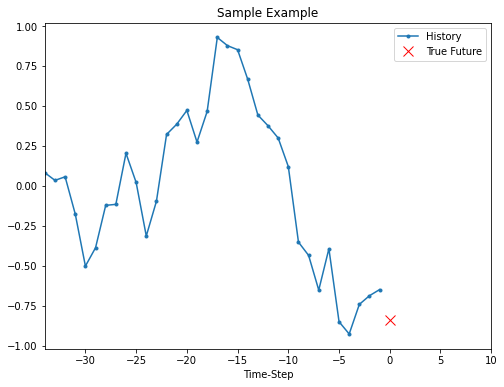

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [ ]:
# Before proceeding to train a model, let's first set a simple baseline. 
# Given an input point, the baseline method looks at all the history and predicts 
# the next point to be the average of the last 20 observations.

In [ ]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

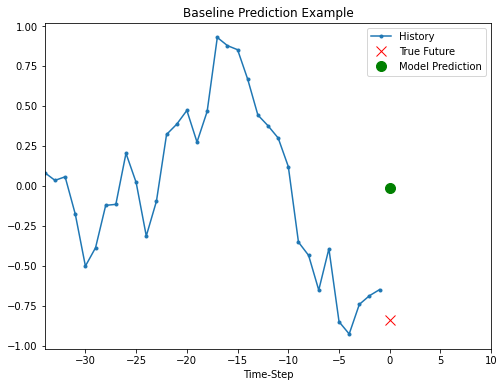

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [ ]:
# We will now try to see if we can beat this baseline using a recurrent neural network.

In [ ]:
# A Recurrent Neural Network (RNN) is a type of neural network well-suited 
# to time series data. RNNs process a time series step-by-step, maintaining 
# an internal state summarizing the information they've seen so far. 
# For more details, read the RNN tutorial. In this tutorial, you will use a 
# specialized RNN layer called Long Short Term Memory (LSTM)

# Let's now use tf.data to shuffle, batch, and cache the dataset.

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(21, 1)


In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 0.5948 - val_loss: 0.4761
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.3366 - val_loss: 0.5463
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.2748 - val_loss: 0.5847
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.2364 - val_loss: 0.6158
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.2090 - val_loss: 0.5957
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1897 - val_loss: 0.5686
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1664 - val_loss: 0.4938
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1273 - val_loss: 0.3868
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1088 - val_loss: 0.3529
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0973 - val_lo

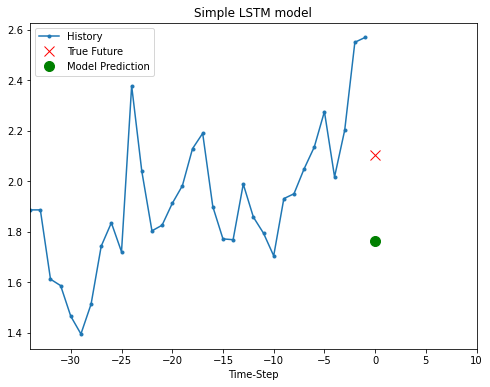

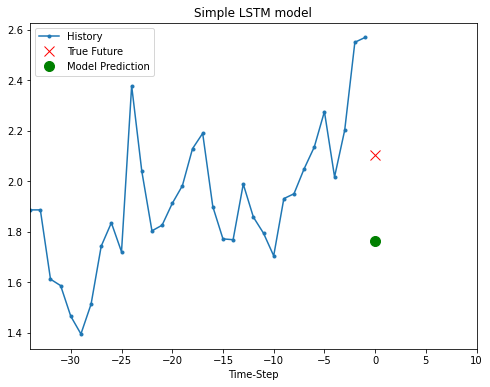

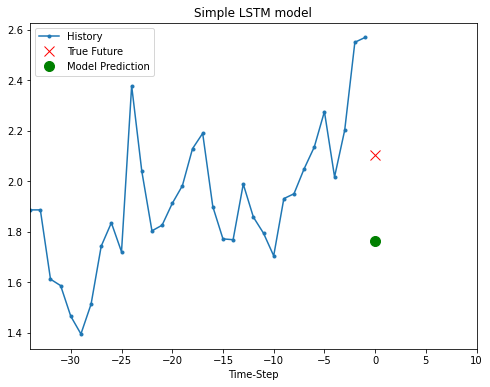

In [ ]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()